In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os


In [2]:

# Load data
X_train = []
Y_train = []
image_size = 150
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']


In [3]:

for i in labels:
    folderPath = os.path.join('./Training', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)

for i in labels:
    folderPath = os.path.join('./Testing', i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        Y_train.append(i)


In [4]:

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train, Y_train = shuffle(X_train, Y_train, random_state=101)


In [5]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=101)


In [6]:

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical([labels.index(i) for i in y_train])
y_test = tf.keras.utils.to_categorical([labels.index(i) for i in y_test])


In [7]:

# Load pre-trained VGG16 model without top (fully connected) layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


In [8]:
# Freeze the convolutional base
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom top layers for classification
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])


In [9]:


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [10]:
        

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])


C:\Anaconda\envs\myenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)



Epoch 1/20
75/75 [==============================] - 17s 142ms/step - loss: 4.3930 - accuracy: 0.5700 - val_loss: 1.2488 - val_accuracy: 0.7857
Epoch 2/20
75/75 [==============================] - 7s 93ms/step - loss: 1.3859 - accuracy: 0.7749 - val_loss: 0.9116 - val_accuracy: 0.8383
Epoch 3/20
75/75 [==============================] - 7s 93ms/step - loss: 0.7835 - accuracy: 0.8441 - val_loss: 0.8190 - val_accuracy: 0.8346
Epoch 4/20
75/75 [==============================] - 7s 93ms/step - loss: 0.5590 - accuracy: 0.8646 - val_loss: 0.7259 - val_accuracy: 0.8496
Epoch 5/20
75/75 [==============================] - 7s 93ms/step - loss: 0.4306 - accuracy: 0.8931 - val_loss: 0.6036 - val_accuracy: 0.8722
Epoch 6/20
75/75 [==============================] - 7s 93ms/step - loss: 0.3014 - accuracy: 0.9091 - val_loss: 0.5760 - val_accuracy: 0.8684
Epoch 7/20
75/75 [==============================] - 7s 93ms/step - loss: 0.2459 - accuracy: 0.9329 - val_loss: 0.5471 - val_accuracy: 0.8759
Epoch 8/20


In [12]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


10/10 [==============================] - 2s 207ms/step - loss: 0.3717 - accuracy: 0.9153
Test Accuracy: 0.9152542352676392


In [13]:
model.save('braintumorvgg.h5')

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

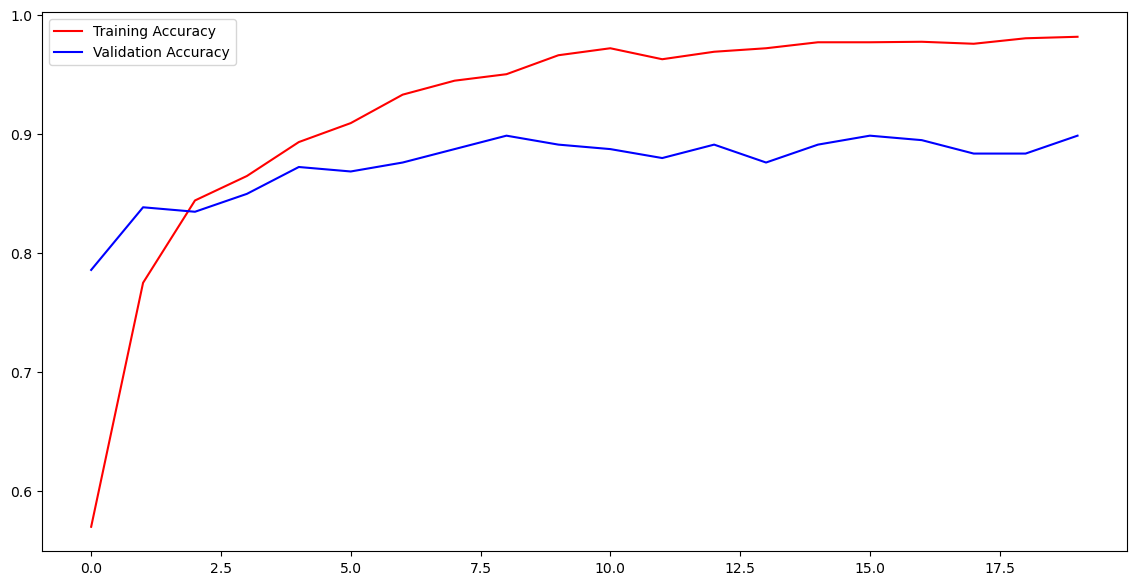

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.legend(loc="upper left")
plt.show()

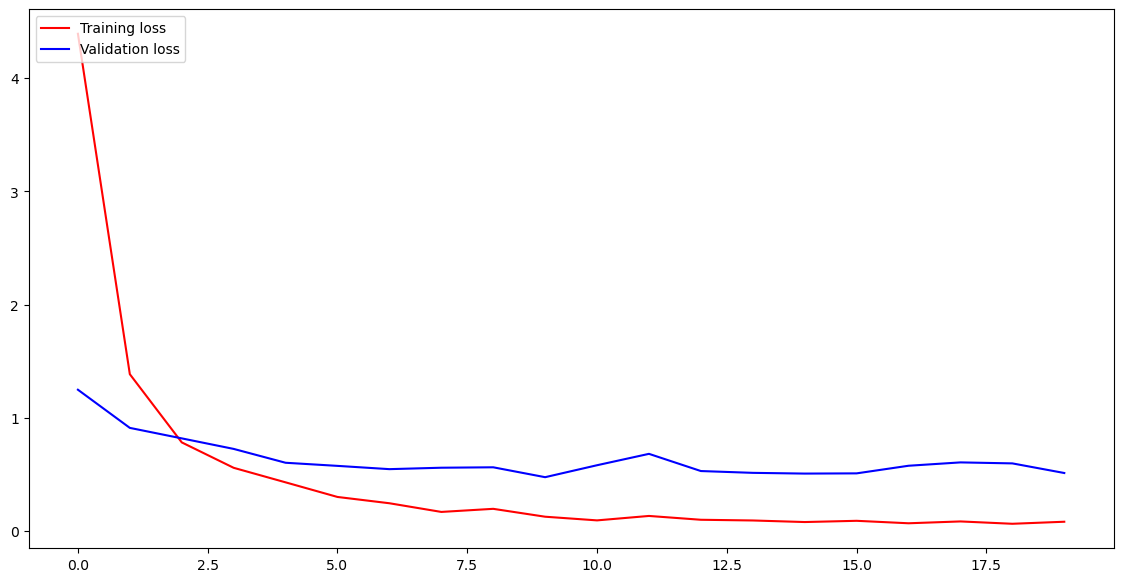

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.legend(loc="upper left")
plt.show()